In [1]:
%matplotlib inline
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy import ndimage
from skimage.external import tifffile
from skimage import transform as tf

# beneath is a list of useful functions
def crop_cms(image,threshold = 100,crop_size = 100):
    '''
    get an area around the centroid of an image
    
    image (2d numpy array): original image waiting to be cropped
    threshold (float): pixels under this threshold will be included in the centroid finding algorithm
    crop_size (int) : the half size of the image
    '''
    # get center of mass
    cms = ndimage.center_of_mass(image<threshold)
    
    # set cropped image size
    xcrop = crop_size
    ycrop = crop_size
    
    # insert a dark frame if tracking fails
    if np.isnan(cms[0]) or np.isnan(cms[1]):
        return np.zeros((xcrop*2, ycrop*2))
    
    # convert center of mass to an integer
    xcm = int(cms[0])
    ycm = int(cms[1])

    # get cropped image boundries
    xl = xcm - xcrop
    xr = xcm + xcrop
    yl = ycm - ycrop
    yr = ycm + ycrop

    # set the correct location in the cropped image
    xst = 0
    xend = xcrop * 2
    yst = 0 
    yend = ycrop * 2

    if xl<0:
        xst = - xl
        xl = 0
    if xr > image.shape[0]:
        xend -= (xr - image.shape[0])
        xr = image.shape[0]
    if yl<0:
        yst = - yl
        yl = 0
    if yr > image.shape[1]:
        yend -= (yr - image.shape[1])
        yr = image.shape[1]

    # set the cropped image
    image_crop = np.zeros((xcrop*2, ycrop*2))
    image_crop[xst:xend,yst:yend] = image[xl:xr,yl:yr]
    return image_crop

def load_avi(fname, nframes = 0, start_frame = 1):
    '''
    load an avi movie to numpy array
    
    fname (str): path to the avi file to be loaded
    nframes (int): number of frames to be loaded, if nframes is 0, will load all frames in the file
    '''
    cap = cv2.VideoCapture(fname)

    # get number of frames in the movie
    all_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    # make sure number of frames is correct under default or extreme conditions
    if nframes == 0 or nframes > all_frames:
        nframes = all_frames
        
    if start_frame>= nframes:
        start_frame = 1

    #get the first frame to get the size of the frame
    ret,frame0rgb = cap.read()
    frame0 = cv2.cvtColor(frame0rgb,cv2.COLOR_BGR2GRAY)
    frame_shape = frame0.shape
    x_pix = frame_shape[0]
    y_pix = frame_shape[1]
    print('The video dimension is x = %dpx y = %dpx n = %dframes' % (x_pix,y_pix,nframes))

    #intiate numpy array
    mov = np.zeros((x_pix,y_pix,nframes-start_frame))
    mov[:,:,0] = frame0

    #load video to numpy array
    for i in range(1,nframes):
        ret, frame_rgb = cap.read()
        if i >= start_frame:
            frame = cv2.cvtColor(frame_rgb,cv2.COLOR_BGR2GRAY)
            mov[:,:,i-start_frame] = frame
        if i % 10 == 0:
            print('Loading in progress %.2f%% of the video is loaded'%(i*100.0/nframes),end = '\r')

    print('Loading is all done! %.2f%% of the video is loaded'%100)
    return mov

def transform_avi(fname, transform, out_shape, nframes = 0, start_frame = 1):
    '''
    load an avi movie to numpy array
    
    fname (str): path to the avi file to be loaded
    nframes (int): number of frames to be loaded, if nframes is 0, will load all frames in the file
    '''
    cap = cv2.VideoCapture(fname)

    # get number of frames in the movie
    all_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    # make sure number of frames is correct under default or extreme conditions
    if nframes == 0 or nframes > all_frames:
        nframes = all_frames
        
    if start_frame>= nframes:
        start_frame = 1

    #get the first frame to get the size of the frame
    ret,frame0rgb = cap.read()
    frame0 = cv2.cvtColor(frame0rgb,cv2.COLOR_BGR2GRAY)
    frame_shape = frame0.shape
    x_pix = frame_shape[0]
    y_pix = frame_shape[1]
    print('The video dimension is x = %dpx y = %dpx n = %dframes' % (x_pix,y_pix,nframes))

    #intiate numpy array
    mov = np.zeros((out_shape[0],out_shape[1],nframes-start_frame))
    warped = tf.warp(frame0, transform, output_shape=out_shape)
    mov[:,:,0] = warped

    #load video to numpy array
    for i in range(1,nframes):
        ret, frame_rgb = cap.read()
        if i >= start_frame:
            frame = cv2.cvtColor(frame_rgb,cv2.COLOR_BGR2GRAY)
            warped = tf.warp(frame, transform, output_shape=out_shape)
            warped = (warped/warped.max() * 255)
            mov[:,:,i-start_frame] = warped
        if i % 10 == 0:
            print('Loading in progress %.2f%% of the video is loaded'%(i*100.0/nframes),end = '\r')

    print('Loading is all done! %.2f%% of the video is loaded'%100)
    return mov

In [2]:
# load raw movie
mov = load_avi('./real_ant/track_mov.avi',start_frame = 5401)
nframes = mov.shape[2]

# choose crop size
csize = 200

# start to crop the movie
mov_crop = np.zeros((csize*2,csize*2,nframes))
for i in range(nframes):
    mov_crop[:,:,i] = crop_cms(mov[:,:,i], threshold = 115, crop_size = csize)
    if i % 60 == 0:
        print('Cropping in progress %.2f%% of the video is cropped'%(i*100.0/nframes),end = '\r')

print('Cropping is all done! %.2f%% of the video is cropped'%100)

The video dimension is x = 512px y = 512px n = 6968frames
Loading is all done! 100.00% of the video is loaded


/home/hao/anaconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:1301: RuntimeWarning: invalid value encountered in double_scalars
  for dir in range(input.ndim)]


Cropping is all done! 100.00% of the video is cropped


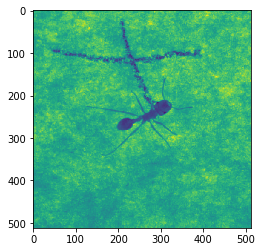

In [3]:
plt.imshow(mov[:,:,300])
plt.show()

In [18]:
# save the image
mov_crop2 = mov_crop.transpose((2,0,1))
tifffile.imsave('./real_ant/track_mov_crop.tif', mov_crop2.astype(np.uint8))

In [6]:
mov_wide = load_avi('./real_ant/wide_mov.avi',nframes = 5501,start_frame = 5401)
image = mov_wide[:,:,1].squeeze()

The video dimension is x = 1200px y = 1920px n = 5501frames
Loading is all done! 100.00% of the video is loaded


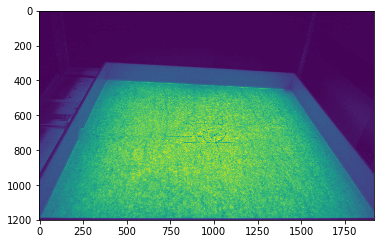

In [7]:
plt.imshow(mov_wide[:,:,90])
plt.show()

<IPython.core.display.Javascript object>


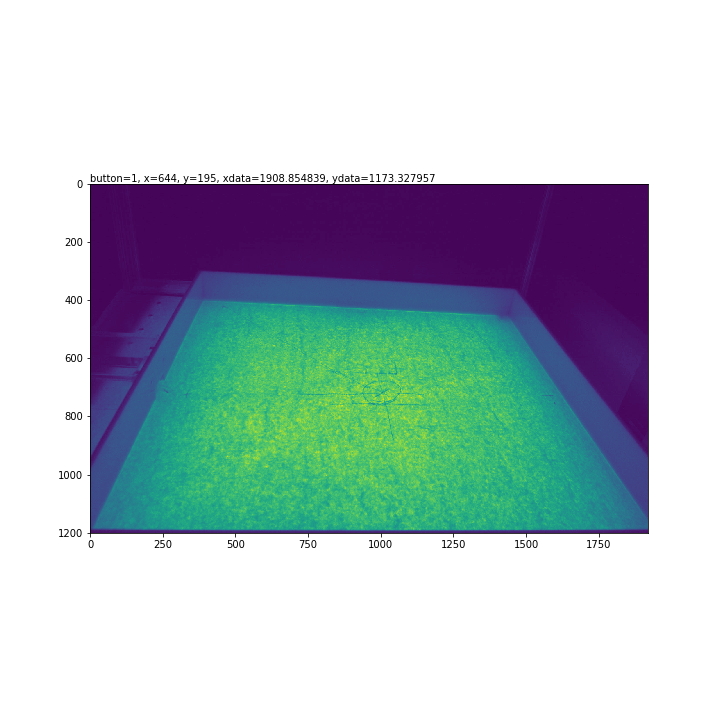

In [16]:
%matplotlib notebook
fig = plt.figure(figsize = [10,10])
ax = fig.add_subplot(111)
ax.imshow(mov_wide[:,:,0])
text=ax.text(0,0, "", va="bottom", ha="left")

def onclick(event):
    tx = 'button=%d, x=%d, y=%d, xdata=%f, ydata=%f' % (event.button, event.x, event.y, event.xdata, event.ydata)
    text.set_text(tx)

cid = fig.canvas.mpl_connect('button_press_event', onclick)

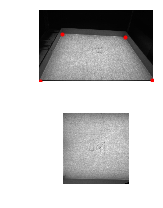

In [30]:

warped = tf.warp(image, tform3, output_shape=(485, 450))

fig, ax = plt.subplots(nrows=2, figsize=(8, 3))

ax[0].imshow(image, cmap=plt.cm.gray)
ax[0].plot(dst[:, 0], dst[:, 1], '.r')
ax[1].imshow(warped, cmap=plt.cm.gray)

for a in ax:
    a.axis('off')

plt.tight_layout()

In [4]:
src = np.array([[0, 485], [0, 0], [485, 485],[485,0]])
dst = np.array([[391, 403], [1448, 454], [10, 1190],[1909,1173]])

tform3 = tf.ProjectiveTransform()
tform3.estimate(src, dst)

mov_wide = transform_avi('./real_ant/wide_mov.avi',tform3,out_shape = (485,485), start_frame = 5401)

The video dimension is x = 1200px y = 1920px n = 6968frames
Loading is all done! 100.00% of the video is loaded


In [5]:
mov_wide2 = mov_wide.transpose((2,0,1))
tifffile.imsave('./real_ant/wide_mov_trans.tif', mov_wide2.astype(np.uint8))

In [ ]:
plt.imshow(mov_wide[:,:,100])
plt.show()